# Problem Set 06: 

0. [Credit for Contributors (required)](#contributors)

1. [RRT Path Planning (100 points)](#problem1)
    1. [Complete the RRT code (50 points)](#rrt)
    2. [Test your code on simple environment (20 points)](#simple_env_code)
    2. [Test your code on given environments (20 points)](#bugtrap_env_code)
    3. [Test your code on harder and random environments (10 points)](#hard_env_code)

    
**100 points** total for Problem Set 6

## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Lec Notes: Motion Planning

## <a name="problem1"></a> Problem 1 : RRT Path Planning

In this problem you will implement the Rapidly-Exploring Random Tree (RRT) algorithm to help a robot navigate from its starting position to the desired end region in an environment full of obstacles.

<img src='rrt_examples.png'/>

You will implement the function `rrt` with the following signature:

```python
def rrt(bounds, environment, start_pose, radius, end_region)
```

where:

- `bounds=(minx, miny, maxx, maxy)` is a tuple that indicates the bounds of the environment (the region the robot can traverse). Example `bounds=(-5, -4, 15, 5)`.
- `environment` is an instance of the `Environment` class that describes the placement of the obstacles in the scene (see more examples below).
- `start_pose = (x,y)` is a tuple indicating the starting position of the robot. Example: `start_pose=(-4, -2)`.
- `radius` is the radius of the robot (used for collision checking). Example `radius=0.1`.
- `end_region` is a `shapely` `Polygon` that describes the region that the robot needs to reach. See examples below.

Your function should:

- return a list of tuples `(x, y)` describing the obstacle free path that takes the robot to the target region. Example of a valid returned path: `[(-4, -2), (-3.71, -1.97), (-3.41, -1.8865), (-3.50, -2.69)]`. Note that your rrt function should produce paths such that the straight line connecting any pair of consecutive points should be obstacle free (considering the obstacles and the size of the robot). In the given example, it should be possible to go from `(-4, -2)` to `(-3.71, -1.97)` in a straight line without colliding with anything.
- produce a plot showing the tree and the obstacle free path (such as the ones shown above)
- show the number of nodes in the tree, the number of nodes in the solution path and the path length (you could put this in the plot title, as in the examples above)


**You are required to submit this notebook with:**

1. The code function `rrt` as described above
2. The results (plots) of using your `rrt` function in the easy and bugtrap environments provided (see code stubs below).
3. The results of using your `rrt` function in a challenging (600 obstacles) environment that is provided.

See the provided example notebook [RRT Helpful Examples](ProblemSet06_RRT_examples.ipynb) for examples on how to use the `Environment` class, the `shapely` library, and how to do some simple collision checking.


<div class="alert alert-info">
**NOTE:** You don't need to write all your code in this notebook if you don't want to. You could create your own `.py` files and then import them into this notebook. We do require that we are able to run the two environments that we provide and the two that you generate in this notebook and that the plots are embedded here.
</div>


<div class="alert alert-warning">
Please ensure that you submit your notebook with the cells already executed. That is, you should save the notebook when your code has been executed and the plots are visible. That way, we will be able to look at your solution initially without running your code first.
</div>



In [9]:
!pip install shapely==1.8.3 --user

  Using cached Shapely-1.8.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.0 MB)


In [1]:
# Useful imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import division
import yaml
import numpy as np
from check_path import check_path
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly

import time

In [2]:
def rrt(bounds, environment, start_pose, radius, end_region):
#bounds=(minx, miny, maxx, maxy)
#environment is an instance of the Environment class that describes the placement of the obstacles in the scene
#start_pose = (x,y)
#radius is the radius of the robot (used for collision checking)
#end_region is a shapely Polygon that describes the region that the robot needs to reach

    starttime = time.time()
    path = []
    num_obstacles = len(environment.obstacles)
    path_length = 0
    num_path_nodes = 0
    N = 1000000000000
    d = radius*2 #max length of path step
    tree_nodes = []
    tree = {start:None} #child:parent
    opptree = dict() #parent:[children]
    start_point = Point(start_pose)
    end_pose = None
    for i in range(N):
        x_rand = SampleFree(bounds,environment,radius) #gives random (x,y) in bounds
        x_nearest = Nearest(x_rand,tree,opptree) #finds closest exisiting tree node
        if x_nearest is None:
            x_nearest = start_pose
        x_new = Steer(x_nearest,x_rand,d)
        if x_new in set(tree_nodes):
            continue
        elif collided(x_nearest,x_new,environment,radius) or out_of_bounds(x_new,bounds):
            continue
        else:
            tree_nodes.append(x_new)
            if x_nearest not in opptree:
                opptree[x_nearest] = [x_new,]
            else:
                templist = opptree[x_nearest].copy()
                templist.append(x_new)
                opptree[x_nearest] = templist
            tree[x_new] = x_nearest
        if at_end(x_new,end_region):
            end_pose = x_new
            break

    num_tree_nodes = len(tree_nodes)
    start_ball = start_point.buffer(radius,resolution=3)
    
    at_coor = end_pose
    
    while at_coor[0]!=start_pose[0] and at_coor[1]!=start_pose[1]:
        parent = tree[at_coor]
        path.append(parent)
        line = LineString([at_coor,parent])
        path_length += line.length
        at_coor = parent
    path.reverse()
    elapsed = time.time()-starttime
    plt.title(str(num_tree_nodes)+" tree nodes. "+str(elapsed)+" seconds. "+str(num_obstacles)+" obstacles. \nPath length: "+str(path_length)+" ("+str(num_path_nodes)+" nodes)")
    ax = plot_environment(environment,bounds)
    plot_poly(ax,start_ball,'magenta')
    plot_poly(ax,end_region,'green')
    for i in range(len(path)-1):
        line = LineString([path[i],path[i+1]])
        plot_line(ax,line)
    for i, obs in enumerate(environment.obstacles):
        plot_poly(ax, obs, color, alpha=1.0, zorder=1)
    plt.plot()
                          
def SampleFree(bounds,environment,radius):
    found = False
    while found is False:
        xcoor = np.random.uniform(bounds[0],bounds[2])
        ycoor = np.random.uniform(bounds[1],bounds[3])
        if collided_one_point((xcoor,ycoor),environment,radius) is False:
            found = True
    return (xcoor,ycoor)
            
def Nearest(x_rand,tree,opptree):
    points_to_check = []
    if x_rand in tree:
        points_to_check.append(tree[x_rand])
    if x_rand in opptree:
        for child in opptree[x_rand]:
            points_to_check.append(child)
    min_dist = float('inf')
    best_coorpair = None
    for coorpair in points_to_check:
        line = LineString([coorpair,x_rand])
        if line.length < min_dist:
            min_dist = line.length
            best_coorpair = coorpair
    return best_coorpair

def Steer(x_nearest,x_rand,d):
    line = LineString([x_nearest,x_rand])
    newpoint = line.interpolate(d)
    return (newpoint.x,newpoint.y)

def collided_one_point(end,environment,radius):
    for i,obs in enumerate(environment.obstacles):
        if obs.contains(Point(end).buffer(radius,resolution=3)):
            return True
    return False

def collided(start,end,environment,radius):
    line = LineString([start,end])
    expanded_line = line.buffer(radius,resolution=3)
    for i,obs in enumerate(environment.obstacles):
        if expanded_line.intersects(obs) or obs.contains(Point(end).buffer(radius,resolution=3)):
            return True
    return False

def out_of_bounds(end,bounds):
    if end[0]<bounds[0] or end[0]>bounds[2]:
        return True
    elif end[1]<bounds[1] or end[1]>bounds[3]:
        return True
    else:
        return False

def at_end(x_new,end_region):
    if end_region.contains(Point(x_new)):
        return True
    else:
        return False

<a name="simple_env_code"></a> **Test your code on the simple environment (20 points)**

In [ ]:
# Test your code in the simple environment
# don't modify this cell. It will be overwritten by the autograder.
# if you want to test things, please create additional cells at the end
environment = Environment('simple.yaml')
radius = 0.3
bounds = (-2, -3, 12, 8)
start = (0, 0)
goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
path = rrt(bounds, environment, start, radius, goal_region)
# The check path function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
check_path(path, bounds, environment, start, radius, goal_region)

/home/jovyan/fa2023-16-410/pset5_rrt/environment.py:136: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  polygon.name = name


<a name="bugtrap_env_code"></a> **Test your code on the bugtrap environment (20 points)**

In [5]:
# Test your code in the bugtrap environment
# don't modify this cell. It will be overwritten by the autograder.
# if you want to test things, please create additional cells at the end
environment = Environment('bugtrap.yaml')
radius = 0.3
bounds = (-2, -3, 12, 8)
start = (2, 2.5)
goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
path = rrt(bounds, environment, start, radius, goal_region)
# The check path function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
check_path(path, bounds, environment, start, radius, goal_region)

AttributeError: 'Polygon' object has no attribute 'name'

<a name="hard_env_code"></a> **Test your code on the harder environment that we have provided (10 points)**

(-5, -4, 15, 5)
(12.019023511183015, 5.5)


IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

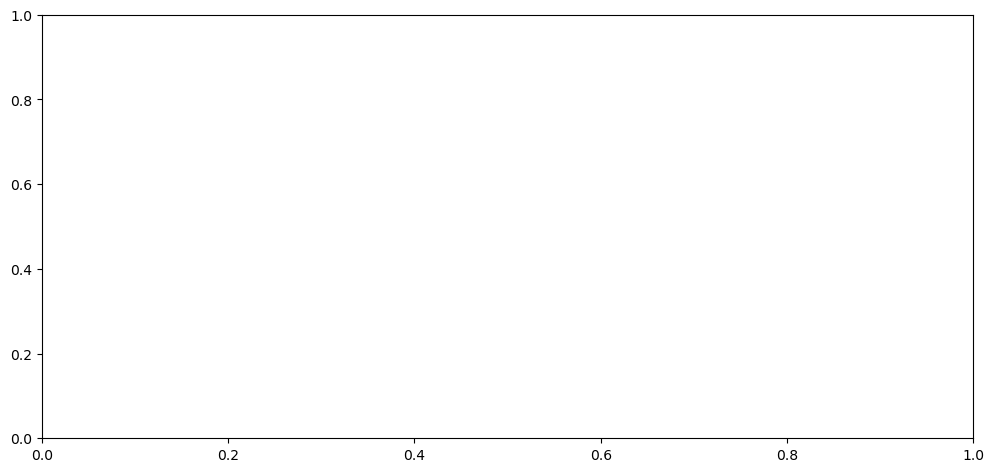

In [6]:
def random_environment(bounds, start, radius, goal, n, size_limits=(0.5, 1.5)):
    minx, miny, maxx, maxy = bounds
    print(bounds)
    edges = 4
    minl, maxl = size_limits
    env = Environment(None)
    obs = []
    start_pose = Point(start).buffer(radius, resolution=3)
    obi = 0
    while obi < n:
        r = np.random.uniform(low=0.0, high=1.0, size=2)
        xy = np.array([minx + (maxx-minx)*r[0], miny + (maxy-miny)*r[1]])
        
        angles = np.random.rand(edges)
        angles = angles*2*np.pi / np.sum(angles)
        for i in range(1,len(angles)):
            angles[i] = angles[i-1] + angles[i]
        angles = 2*np.pi * angles / angles[-1] 
        angles = angles + 2*np.pi*np.random.rand()
        lengths = 0.5*minl + (maxl-minl) * 0.5 * np.random.rand(edges)
        xx = xy[0] + np.array([l*np.cos(a) for a,l in zip(angles,lengths)])
        yy = xy[1] + np.array([l*np.sin(a) for a,l in zip(angles,lengths)])
        p = Polygon([(x,y) for x,y in zip(xx,yy)])
        if p.intersects(start_pose) or p.intersects(goal):
            continue
        else:
            obi = obi + 1
            obs.append(p)
#         coords = xy + [l*np.cos(a),l*np.sin(a) for a,l in zip(angles,lengths)]
    env.add_obstacles(obs)
    return env


start = (-4,-2)
radius = 0.1
goal_region = Polygon([(12,3), (12,4), (13,4),(13,3)])
bounds = (-5, -4, 15, 5)
env = random_environment(bounds, start, radius, goal_region, 600, (0.2, 0.4))
plot_environment(env)

In [7]:
env.save_to_yaml('challenging600.yaml')

In [8]:
# Test your code in the challenging environment that you made
environment = Environment('challenging600.yaml')
# radius = 0.2
# bounds = (-2, -3, 12, 8)
# start = (2, 2.5)
# goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
path = rrt(bounds, environment, start, radius, goal_region)
# The check path function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
check_path(path, bounds, environment, start, radius, goal_region)

AttributeError: 'Polygon' object has no attribute 'name'